# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import math

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import dask

import vector
import particle
import hepunits

import comet_ml
import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader, Subset

from memflow.dataset.data import ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.ttH_dataclasses import ttHHardDataset, ttHRecoDataset
from memflow.callbacks.transfer_flow_callbacks import SamplingCallback, BiasCallback

from models.conditional_flow_matching import TransferCFM
from models.utils import plot_trajectories, compare_distributions
from models.callbacks import CFMSamplingCallback

vector.register_awkward()

os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='cuda':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|----------------------

# Data

In [2]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    N = int(1e5),
)

print (data_hard)

Data object
Loaded branches:
   ... file: 100000
   ... sample: 100000
   ... tree: 100000
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi
  

# Hard dataset

In [3]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)

obj = hard_dataset.objects['neutrinos']

# 1) Check its type
print("Type of neutrinos object:", type(obj))

# 2) If it’s a tuple, print its length
if isinstance(obj, tuple):
    print("Length of tuple:", len(obj))
    for i, element in enumerate(obj):
        print(f"Element {i} has type {type(element)} and shape/length:", end=" ")
        # If element is a torch.Tensor or numpy array:
        if hasattr(element, 'shape'):
            print(element.shape)
        # If it's a list of fields, you might just print:
        else:
            print(element)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard


Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Type of neutrinos object: <class 'tuple'>
Length of tuple: 3
Element 0 has type <class 'torch.Tensor'> and shape/length: torch.Size([39842, 4, 5])
Element 1 has type <class 'torch.Tensor'> and shape/length: torch.Size([39842, 4])
Element 2 has type <class 'torch.Tensor'> and shape/length: torch.Size([39842, 4])


In [4]:
data, mask, weights = hard_dataset.objects["neutrinos"]

# 1) Slice out the first neutrino on the second axis
data_sliced = data[:, 0:1, :]     # shape => (39842, 1, 5)
mask_sliced = mask[:, 0:1]        # shape => (39842, 1)
weights_sliced = weights[:, 0:1]  # shape => (39842, 1)

# 2) Re-pack them into a tuple
hard_dataset.objects["neutrinos"] = (data_sliced, mask_sliced, weights_sliced)

print("New shape of neutrinos data:", hard_dataset.objects["neutrinos"][0].shape)
# Should now be (39842, 1, 5)

print(hard_dataset.objects["neutrinos"])

New shape of neutrinos data: torch.Size([39842, 1, 5])
(tensor([[[ 0.5272,  0.3338, -1.6739, -0.8235, 14.0000]],

        [[-0.4475, -0.4298, -0.3355, -0.8235, 16.0000]],

        [[-2.8284, -2.9229,  0.1775, -0.8235, 14.0000]],

        ...,

        [[-1.3576,  1.1838, -1.3842, -0.8235, 12.0000]],

        [[-1.0862, -0.1595, -0.3485, -0.8235, 14.0000]],

        [[-1.4150,  0.2544,  0.6310, -0.8235, 16.0000]]]), tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]), tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]))


In [5]:
print(hard_dataset.objects["neutrinos"])

(tensor([[[ 0.5272,  0.3338, -1.6739, -0.8235, 14.0000]],

        [[-0.4475, -0.4298, -0.3355, -0.8235, 16.0000]],

        [[-2.8284, -2.9229,  0.1775, -0.8235, 14.0000]],

        ...,

        [[-1.3576,  1.1838, -1.3842, -0.8235, 12.0000]],

        [[-1.0862, -0.1595, -0.3485, -0.8235, 14.0000]],

        [[-1.4150,  0.2544,  0.6310, -0.8235, 16.0000]]]), tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]), tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]))


In [6]:
# Merge "quarks" + "bottoms" => "partons"
# 1) Retrieve the 4-tuple or 3-tuple from each
q_obj = hard_dataset.objects["quarks"]    # e.g. (q_data, q_mask, q_weights)
b_obj = hard_dataset.objects["bottoms"]   # e.g. (b_data, b_mask, b_weights)

q_data, q_mask, q_weights = q_obj
q_fields = ['pt','eta','phi','mass','pdgId']
b_data, b_mask, b_weights = b_obj
b_fields = ['pt','eta','phi','mass','pdgId']

# 2) Concatenate along axis=1 => shape (B, 6, F)
partons_data = torch.cat([b_data, q_data], dim=1)
partons_mask = torch.cat([b_mask, q_mask], dim=1)
partons_weights = torch.cat([b_weights, q_weights], dim=1)

# 3) Combine the fields (you can unify if they differ, or just pick one set)
partons_fields = list(set(q_fields + b_fields))

# 4) Register the new combined object
hard_dataset.objects["partons"] = (partons_data, partons_mask, partons_weights)
hard_dataset.fields["partons"]  = partons_fields

# 5) Remove old entries
del hard_dataset.objects["quarks"]
del hard_dataset.objects["bottoms"]

# 6) Update the selection to have exactly two types: "partons" (6) and "neutrinos" (1).
hard_dataset.selection = ["partons", "neutrinos"]
hard_dataset.metadata["selection"] = ["partons", "neutrinos"]
# If your dataset logic also stores "number_particles_per_type", update that:
hard_dataset.metadata["n_objects_per_type"] = [6, 1]  # or whatever attribute your code uses

Before preprocessing


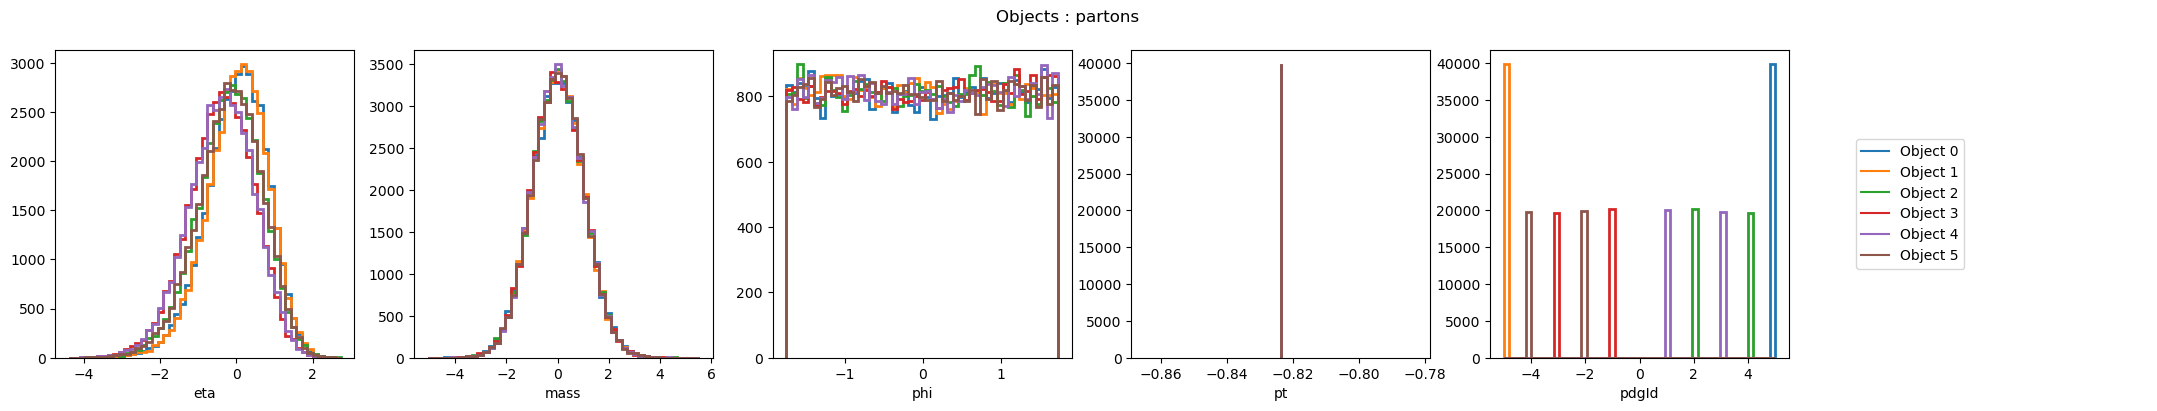

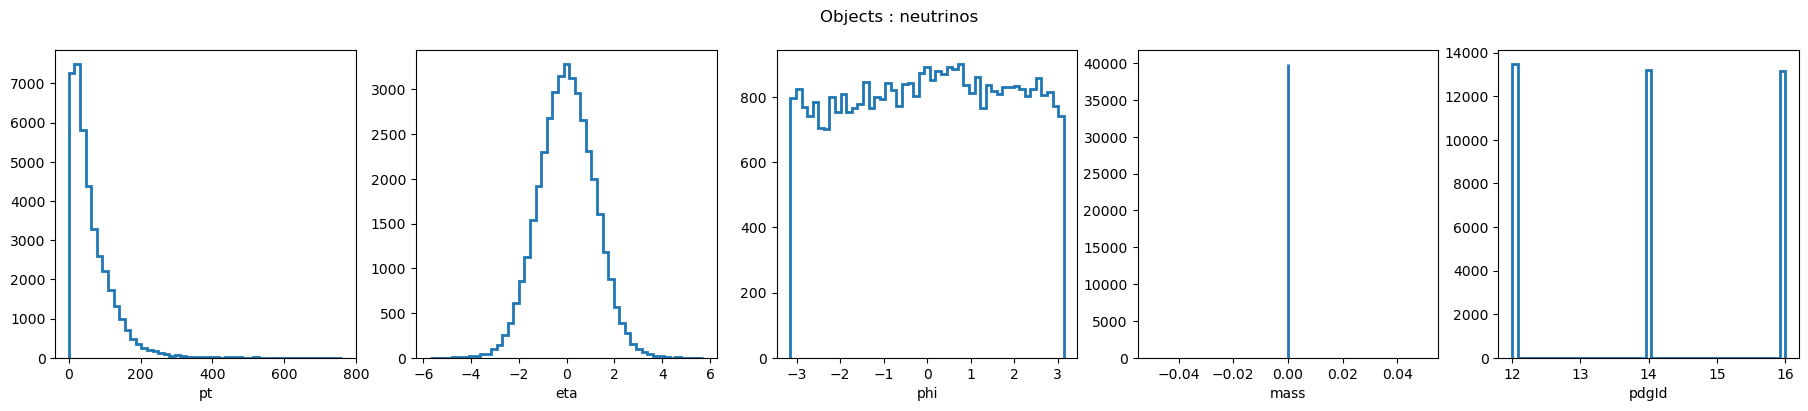

After preprocessing


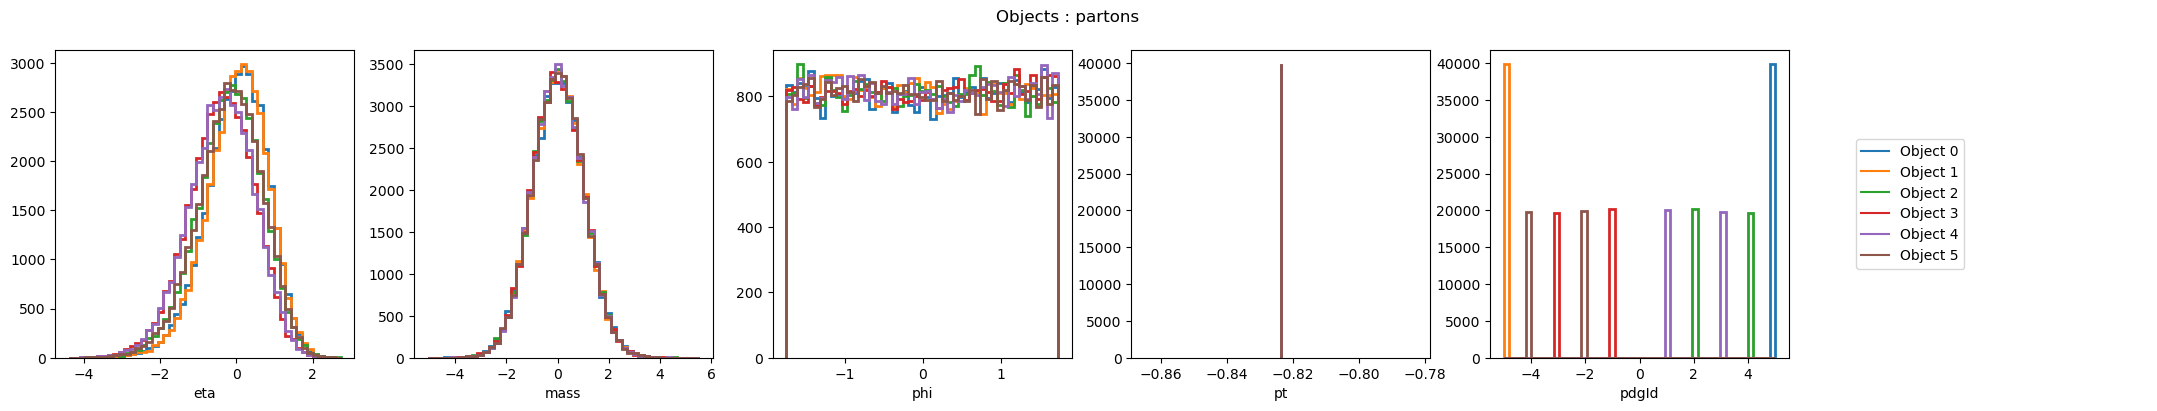

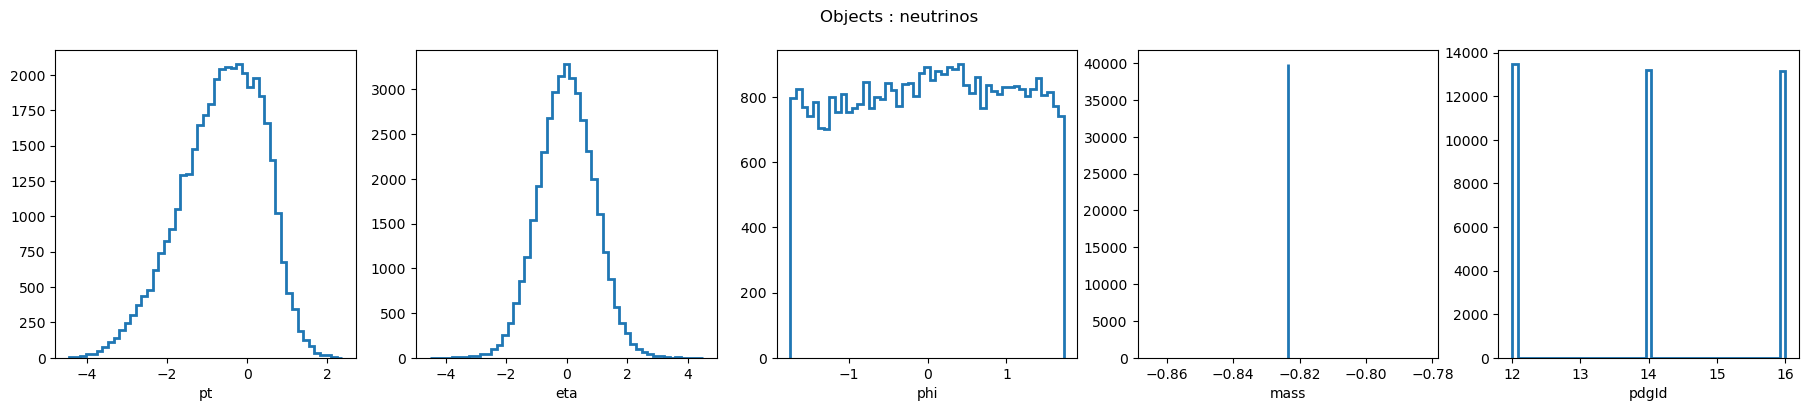

In [7]:
print ('Before preprocessing')
hard_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
hard_dataset.plot(selection=True,raw=False)

In [8]:
# This is not strictly necessary, but just to make sure loading works as expected
# We will use later a combined dataset (hard+reco) below
hard_loader = DataLoader(
    hard_dataset,
    batch_size = 32,
)
batch = next(iter(hard_loader))

for obj,mask,sel in zip(batch['data'],batch['mask'],hard_loader.dataset.selection):
    print (sel,obj.shape,mask.shape)

partons torch.Size([32, 6, 5]) torch.Size([32, 6])
neutrinos torch.Size([32, 1, 5]) torch.Size([32, 1])


# Reco dataset

In [9]:
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
    N = data_hard.N,
)

print (data_reco)

Data object
Loaded branches:
   ... file: 100000
   ... sample: 100000
   ... tree: 100000
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... InputMet_phi
   ... InputMet_pt
   ... cleanedJet_btagDeepFlavB
   ... cleanedJet_eta
   ... cleanedJet_mass
   ... cleanedJet_phi
   ... cleanedJet_pt
   ... event
   ... ncleanedBJet
   ... ncleanedJet
   ... region
   ... weight_nominal
   ... xs_weight


In [10]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco


Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Reco dataset with 49446 events
Containing the following tensors
jets  : data ([49446, 6, 5]), mask ([49446, 6])
        Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%]
        Mask attn     : [True, True, True, True, True, True]
        Weights       : 49446.00, 49446.00, 49446.00, 49446.00, 49446.00, 49446.00
        Features      : ['pt', 'eta', 'phi', 'mass', 'btag']
        Selected for batches : True
met   : data ([49446, 1, 4]), mask ([49446, 1])
        Mask exist    : [100.00%]
        Mask attn     : [True]
        Weights       : 49446.00
        Features      : ['pt', 'eta', 'phi', 'mass']
        Selected for batches : True
Preprocessing steps
Step applied

In [11]:
# print("Dataset data keys:")
# print(reco_dataset.data.keys())  # List all branches in the dataset

# print("Jets branch (first 5):")
# print(reco_dataset.data["cleanedJet_pt"][:5])

# print("Registered objects:")
# print(reco_dataset.objects)

print("JETS:")
print(len(reco_dataset.objects['jets'][0])) #Dims: [[event], [jet number], [pt, eta, phi, mass, btag]]


JETS:
49446


Before preprocessing


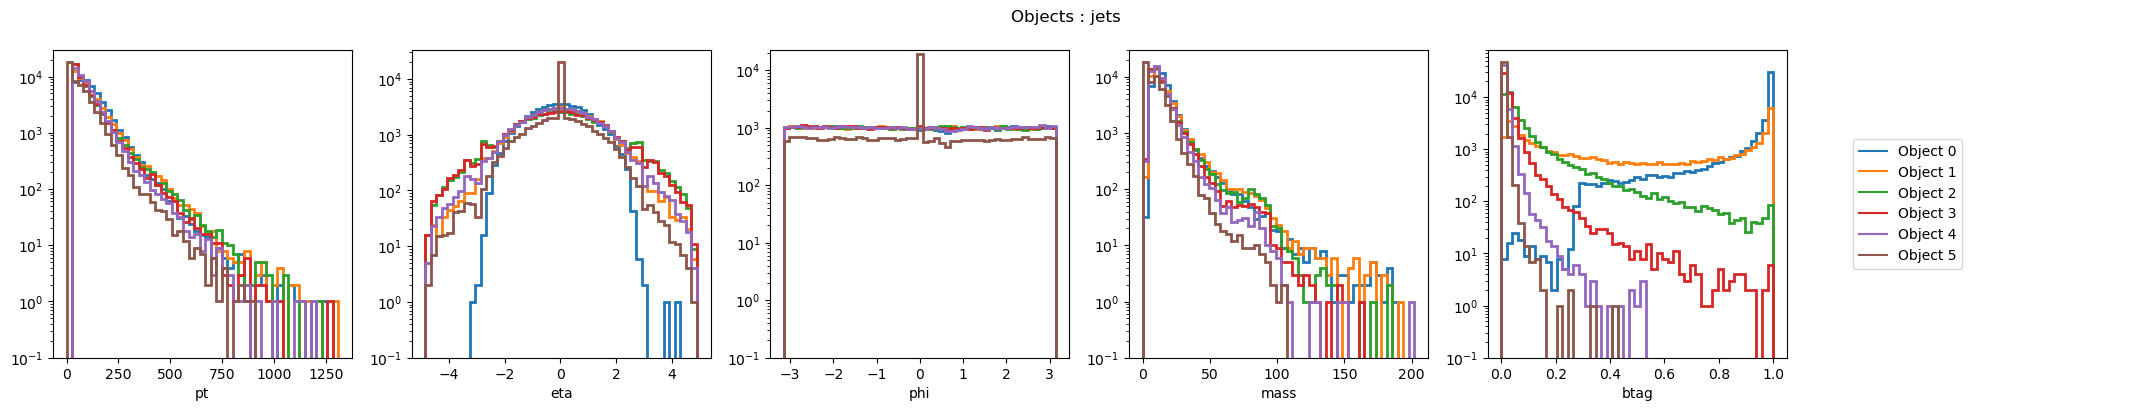

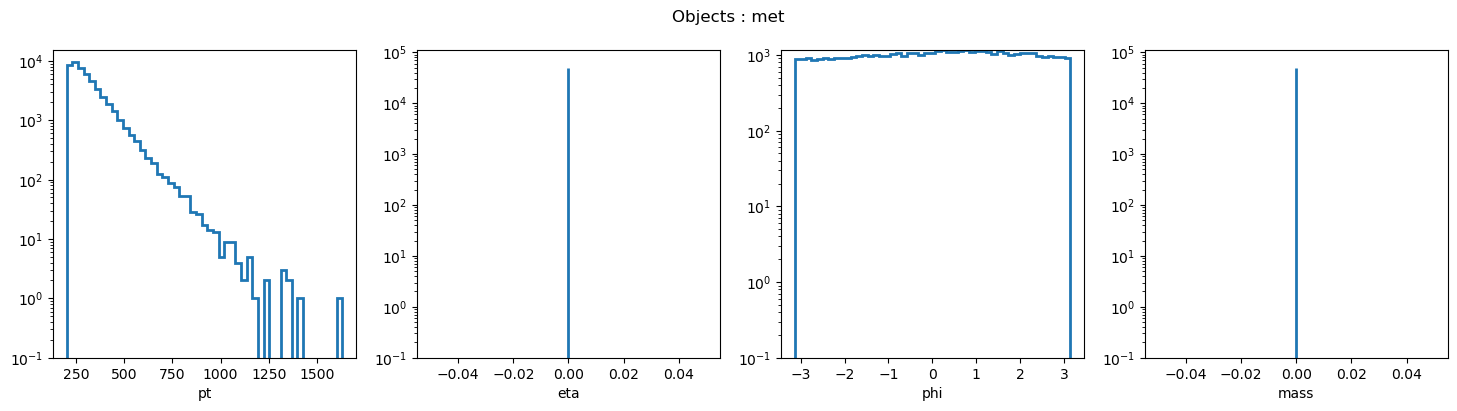

After preprocessing


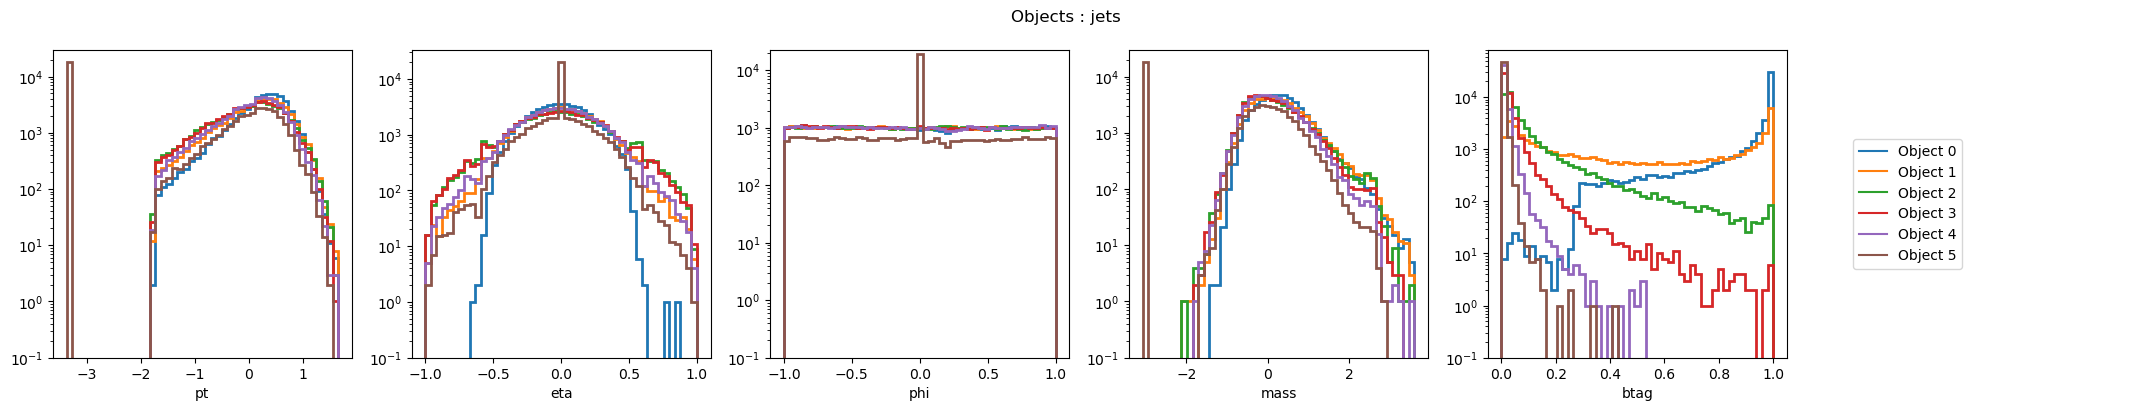

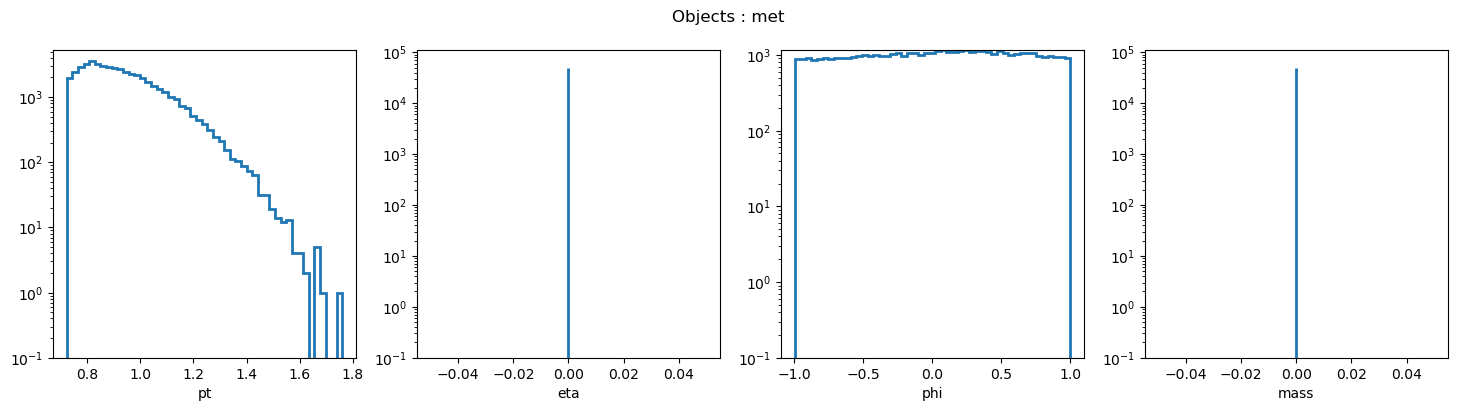

In [12]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

In [13]:
# Also not needed, just checking 
reco_loader = DataLoader(
    reco_dataset,
    batch_size = 32,
)
batch = next(iter(reco_loader))

for obj,mask,sel in zip(batch['data'],batch['mask'],reco_loader.dataset.selection):
    print (sel,obj.shape,mask.shape)

jets torch.Size([32, 6, 5]) torch.Size([32, 6])
met torch.Size([32, 1, 4]) torch.Size([32, 1])


# Combined dataset

In [14]:
print(f'Intersection Branch: {reco_dataset.intersection_branch}')
print (f'Hard Datset keys: {hard_dataset.metadata.keys()}')
print (f'Reco Datset keys: {reco_dataset.metadata.keys()}')

combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)
print(combined_dataset)

Intersection Branch: event
Hard Datset keys: dict_keys(['file', 'tree', 'sample', 'intersection', 'selection', 'n_objects_per_type'])
Reco Datset keys: dict_keys(['file', 'tree', 'sample', 'intersection'])
Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 39842 events, 4828 selected
For entry 1 : from 49446 events, 4828 selected
Combined dataset (extracting 4828 events of the following) :
Parton dataset with 39842 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
Zs         : data ([39842, 2, 5]), mask ([39842, 2])
             Mask exist    : [100.00%, 100.00%]
       

In [15]:
combined_loader = DataLoader(
    combined_dataset,
    batch_size = 256,
)
batch = next(iter(combined_loader))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],combined_loader.dataset.reco_dataset.selection):
    print (sel,obj.shape,mask.shape)

print ('Hard')
for obj,mask,sel in zip(batch['hard']['data'],batch['hard']['mask'],combined_loader.dataset.hard_dataset.selection):
    print (sel,obj.shape,mask.shape)

Reco
jets torch.Size([256, 6, 5]) torch.Size([256, 6])
met torch.Size([256, 1, 4]) torch.Size([256, 1])
Hard
partons torch.Size([256, 6, 5]) torch.Size([256, 6])
neutrinos torch.Size([256, 1, 5]) torch.Size([256, 1])


In [ ]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.8
indices = torch.arange(len(combined_dataset))
sep = int(train_frac*len(combined_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

combined_dataset_train = torch.utils.data.Subset(combined_dataset,train_indices)
combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
print (f'Dataset : training {len(combined_dataset_train)} / validation {len(combined_dataset_valid)}')

batch_size = 1024

combined_loader_train = DataLoader(
    combined_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
combined_loader_valid = DataLoader(
    combined_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)
print (f'Batching {len(combined_loader_train)} / Validation {len(combined_loader_valid)}')

Dataset : training 3862 / validation 966
Batching 4 / Validation 1


# Transfer flow

In [ ]:
print(combined_dataset.hard_dataset.input_features) # Determine the available features that you can select in ` flow_input_features`
# Note the length of this (2 elements) must match the length of  `flow_input_features`
# But you dont have to select all the features in each element
print(combined_dataset.reco_dataset.input_features)

(('eta', 'mass', 'phi', 'pt', 'pdgId'), ('pt', 'eta', 'phi', 'mass', 'pdgId'))
(('pt', 'eta', 'phi', 'mass', 'btag'), ('pt', 'eta', 'phi', 'mass'))


In [18]:
# Instantiate CFM model
model = TransferCFM(
    embed_dims=[32, 64],
    embed_act=nn.GELU,
    dropout=0.0,

    n_hard_particles_per_type=[6, 1],
    hard_particle_type_names=["partons", "neutrinos"],
    hard_input_features_per_type=[ # These are all the features available, speciefied in dataclass
        ['pt','eta','phi','mass','pdgId'],
        ['pt','eta','phi','mass','pdgId']
    ],

    n_reco_particles_per_type=[6, 1],
    reco_particle_type_names=["jets", "met"],
    reco_input_features_per_type=[
        ["pt","eta","phi","mass","btag"],  # jets
        ["pt","eta","phi","mass",],         # met
    ],

    # Only pick a subset in bridging:
    flow_input_features = [
        ["pt","eta","phi"],  # partons->jets
        ["pt","phi"],        # neutrinos->met
    ],

    hard_mask_attn=None,
    reco_mask_attn=reco_dataset.attention_mask,
    transformer_args={
        "nhead": 8,
        "num_encoder_layers": 8,
        "num_decoder_layers": 8,
        "dim_feedforward": 128,
        "activation": "gelu",
    },
    sigma=0.1,
)

model = model.cpu()

# Quick test on one batch
batch = next(iter(combined_loader_train))
loss = model(batch)
print("Initial CFM loss:", loss.item())

print(model)

Initial CFM loss: 1.4008817672729492
TransferCFM(
  (hard_embeddings): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1):

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [19]:
print(type(batch['hard']['data']), len(batch['hard']['data'])) # len = 2 is for 2 particles
print(type(batch['reco']['data']), len(batch['reco']['data']))

print(batch['hard']['data']) # shape [batch_size, num_particles, num_features]

<class 'list'> 2
<class 'list'> 2
[tensor([[[ 0.5953, -0.3751,  1.3185, -0.8235,  5.0000],
         [ 0.2654, -0.8032, -1.7042, -0.8235, -5.0000],
         [-1.4248, -1.1765, -1.1852, -0.8235,  2.0000],
         [-0.1380, -0.3141,  0.5704, -0.8235, -1.0000],
         [-0.3307, -0.0816, -1.6912, -0.8235,  1.0000],
         [-0.8950,  0.3230, -0.4252, -0.8235, -2.0000]],

        [[-0.1969,  2.4396,  0.8277, -0.8235,  5.0000],
         [-0.2112,  1.3289,  0.2710, -0.8235, -5.0000],
         [ 0.6854,  1.3011,  0.7823, -0.8235,  2.0000],
         [-2.3037,  2.8963,  0.6634, -0.8235, -1.0000],
         [-0.6395,  2.2977, -0.9150, -0.8235,  1.0000],
         [-0.4763,  1.7547,  1.3488, -0.8235, -2.0000]],

        [[ 0.1902,  0.0095, -1.1593, -0.8235,  5.0000],
         [ 0.5211,  1.0049, -0.4544, -0.8235, -5.0000],
         [-0.5113,  0.0089, -0.3193, -0.8235,  2.0000],
         [-0.7370, -0.5548,  0.9402, -0.8235, -1.0000],
         [ 0.5491,  0.3546, -0.1177, -0.8235,  3.0000],
         

In [20]:
# 4) Optimizer + scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.set_optimizer(optimizer)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=0.1,
    patience=10,
    threshold=0.001,
    threshold_mode='rel',
    cooldown=0,
    min_lr=1e-7
)
model.set_scheduler_config({
    'scheduler': scheduler,
    'interval': 'epoch',
    'frequency': 1,
    'monitor': 'val_loss',  # <-- or 'val/loss_tot' if you prefer
    'strict': True,
    'name': 'scheduler',
})

# 5) Logger + Trainer
logger = pl_loggers.CometLogger(
    save_dir='../comet_logs',
    project_name='mem-flow-ttH',
    experiment_name='combined',
    offline=False,
)

epochs = 500
steps_per_epoch_train = math.ceil(len(combined_dataset_train)/combined_loader_train.batch_size)

cfm_sampling_cb = CFMSamplingCallback(
    dataset=combined_dataset_valid,
    freq=5,  # Plot every 5 epochs
    steps=10,  # Number of bridging steps
    show_sampling_distributions=True  # Enable sampling distribution plots
)

trainer = L.Trainer(
    min_epochs=5,
    max_epochs=epochs,
    callbacks=None,
    devices='auto',
    accelerator='auto',
    logger=logger,
    log_every_n_steps=steps_per_epoch_train // 100,
)

# 6) Fit
trainer.fit(
    model=model,
    train_dataloaders=combined_loader_train,
    val_dataloaders=combined_loader_valid,
)

logger.experiment.end()

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Experiment is live on comet.com https://www.comet.com/themrluke/mem-flow-tth/6e16a8de4a284060989d1fe44a62f356

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name            | Type        | Params | Mode 
--------------------------------------------------------
0 | hard_embeddings | ModuleList  | 4.6 K  | train
1 | reco_embeddings | ModuleList  | 4.6 K  | train
2 | transformer     | Transformer | 669 K  | train
3 | vel_nets        | ModuleList  | 51.2 K | train
--------------------------------------------------------
730 K     Trainable params
0         Non-trainable params
730 K     Total params
2.921     Total estimated model params size (MB)
230       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : combined
COMET INFO:     url                   : https://www.comet.com/themrluke/mem-flow-tth/6e16a8de4a284060989d1fe44a62f356
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [200]     : (0.1264180988073349, 1.4256075620651245)
COMET INFO:     val_loss [500] : (0.12435869872570038, 1.0208357572555542)
COMET INFO:   Others:
COMET INFO:     Name : combined
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     fi

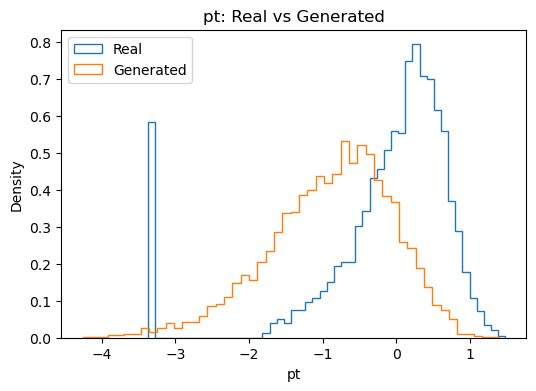

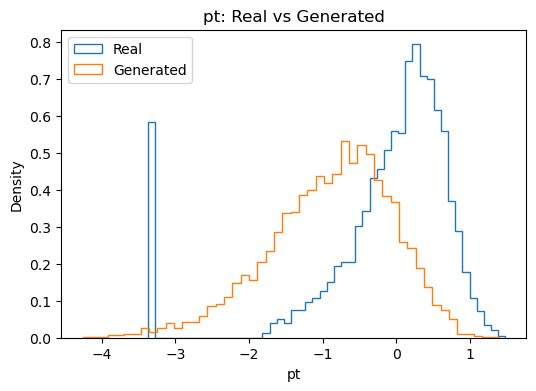

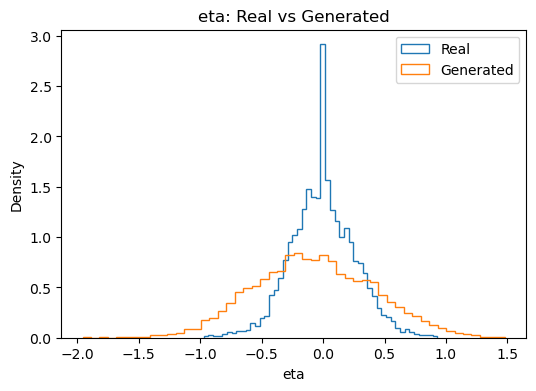

In [21]:
# After training is done, let's do a quick distribution comparison manually:

batch = next(iter(combined_loader_valid))
batch = CFMSamplingCallback.move_batch_to_device(batch, model.device)

with torch.no_grad():
    model = model.to(model.device)
    gen_data_list = model.sample(batch, steps=10)

real_data = batch["reco"]["data"][0]
gen_data  = gen_data_list[0]
compare_distributions(real_data, gen_data, feat_idx=0, feat_name="pt")

# Let's say feature_idx=0 => "pt"
compare_distributions(real_data, gen_data, feat_idx=0, feat_name="pt")

# Possibly also feature_idx=1 => "eta"
compare_distributions(real_data, gen_data, feat_idx=1, feat_name="eta")

Plotting sampling distributions for jets (event 0):


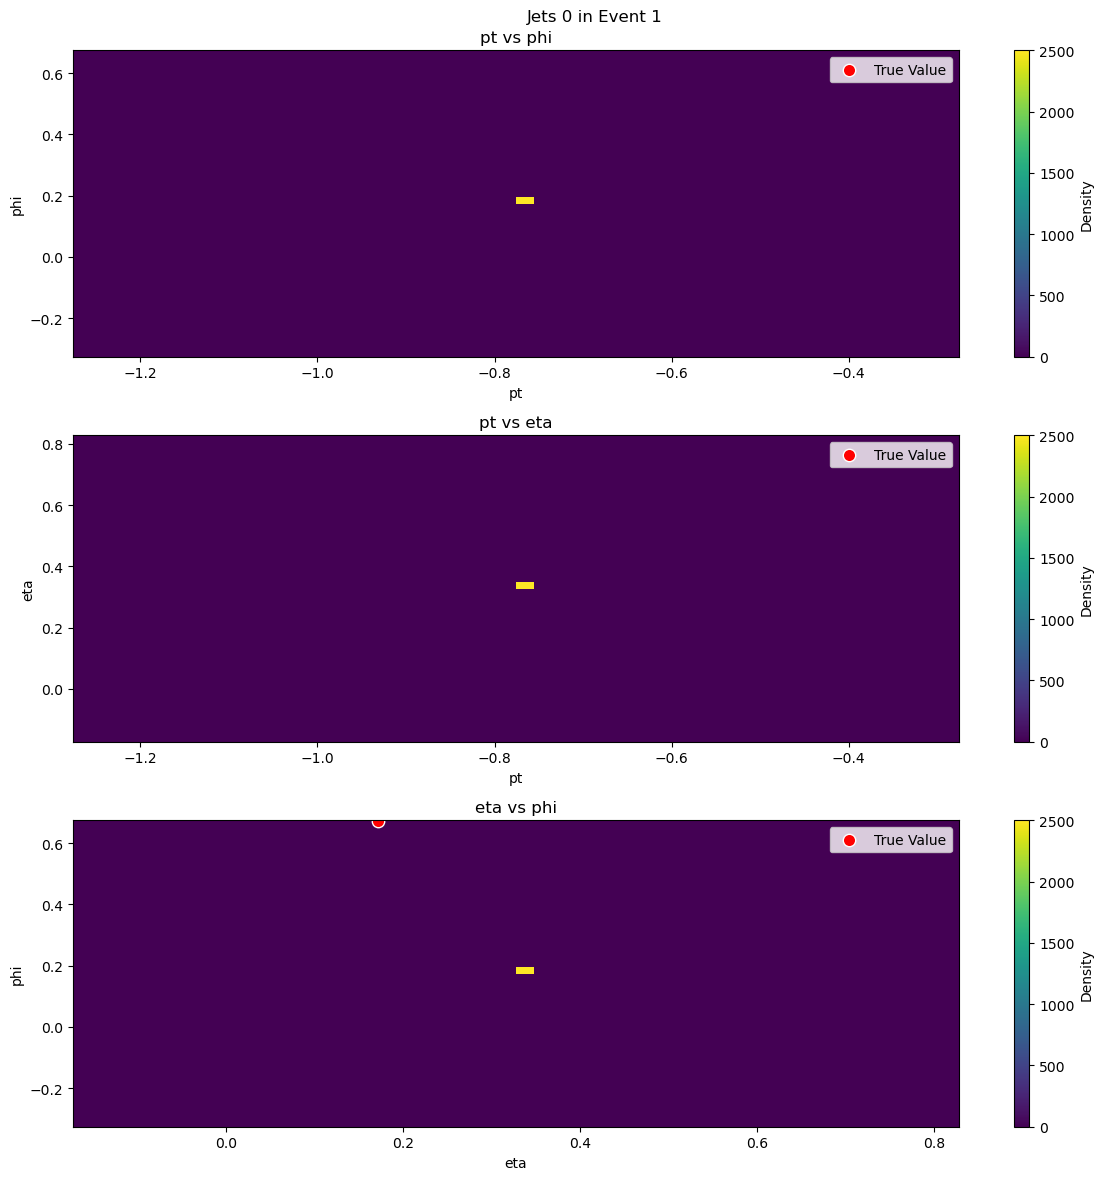

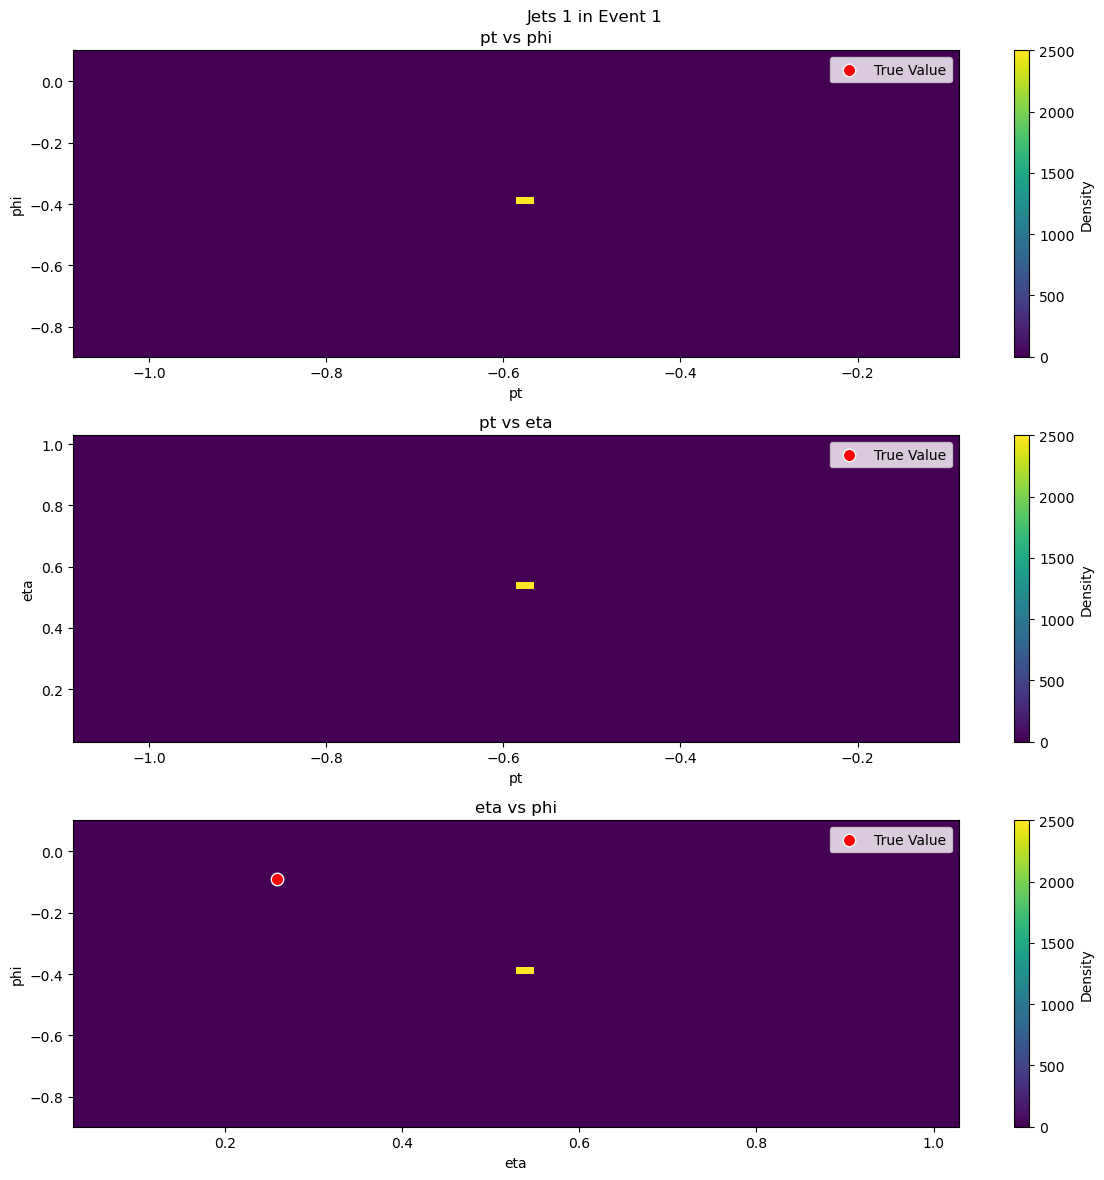

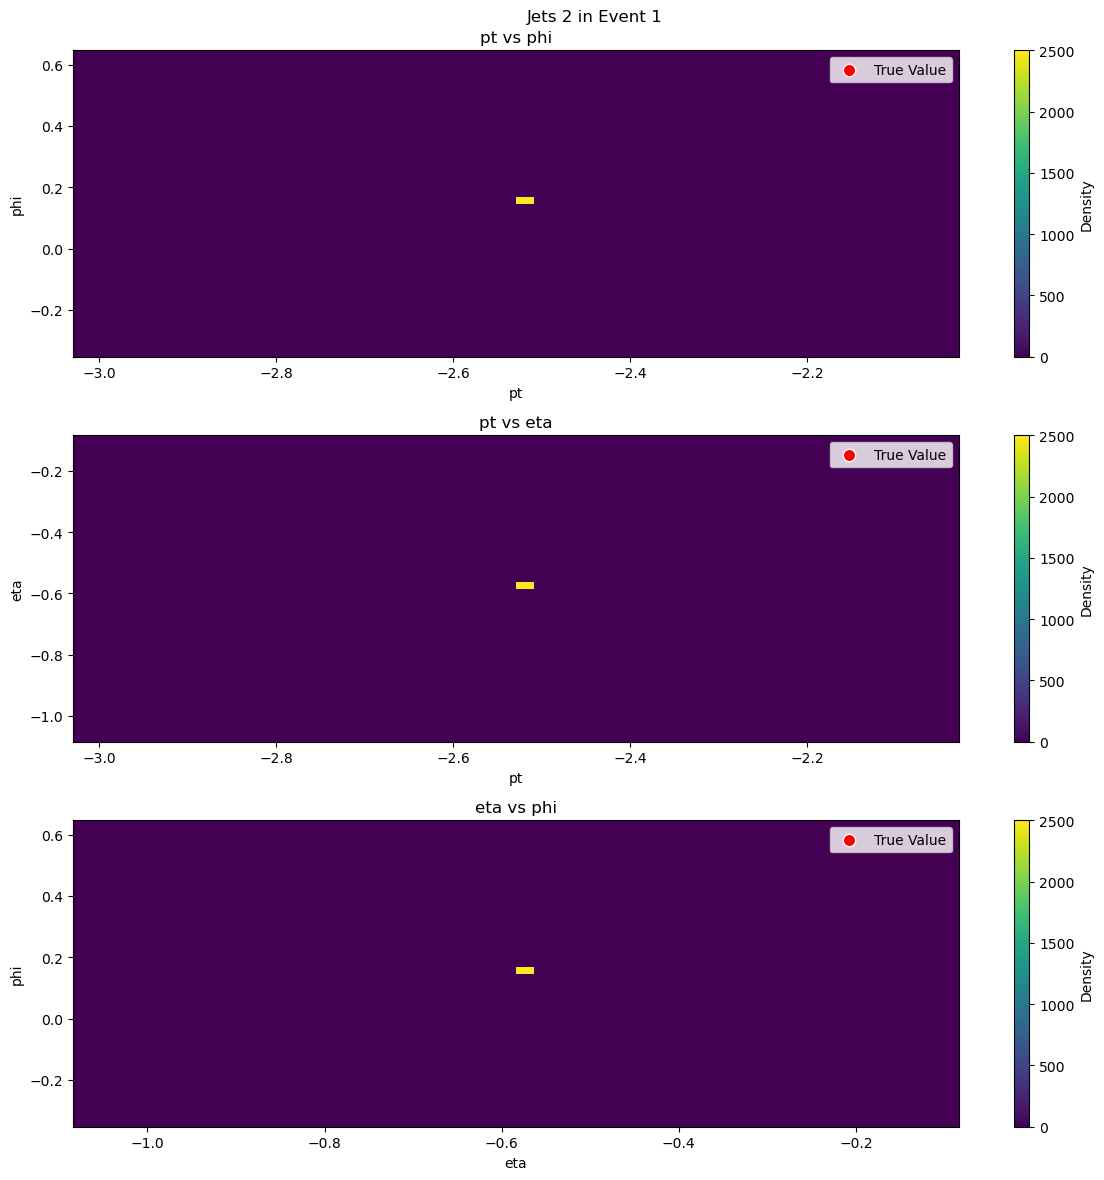

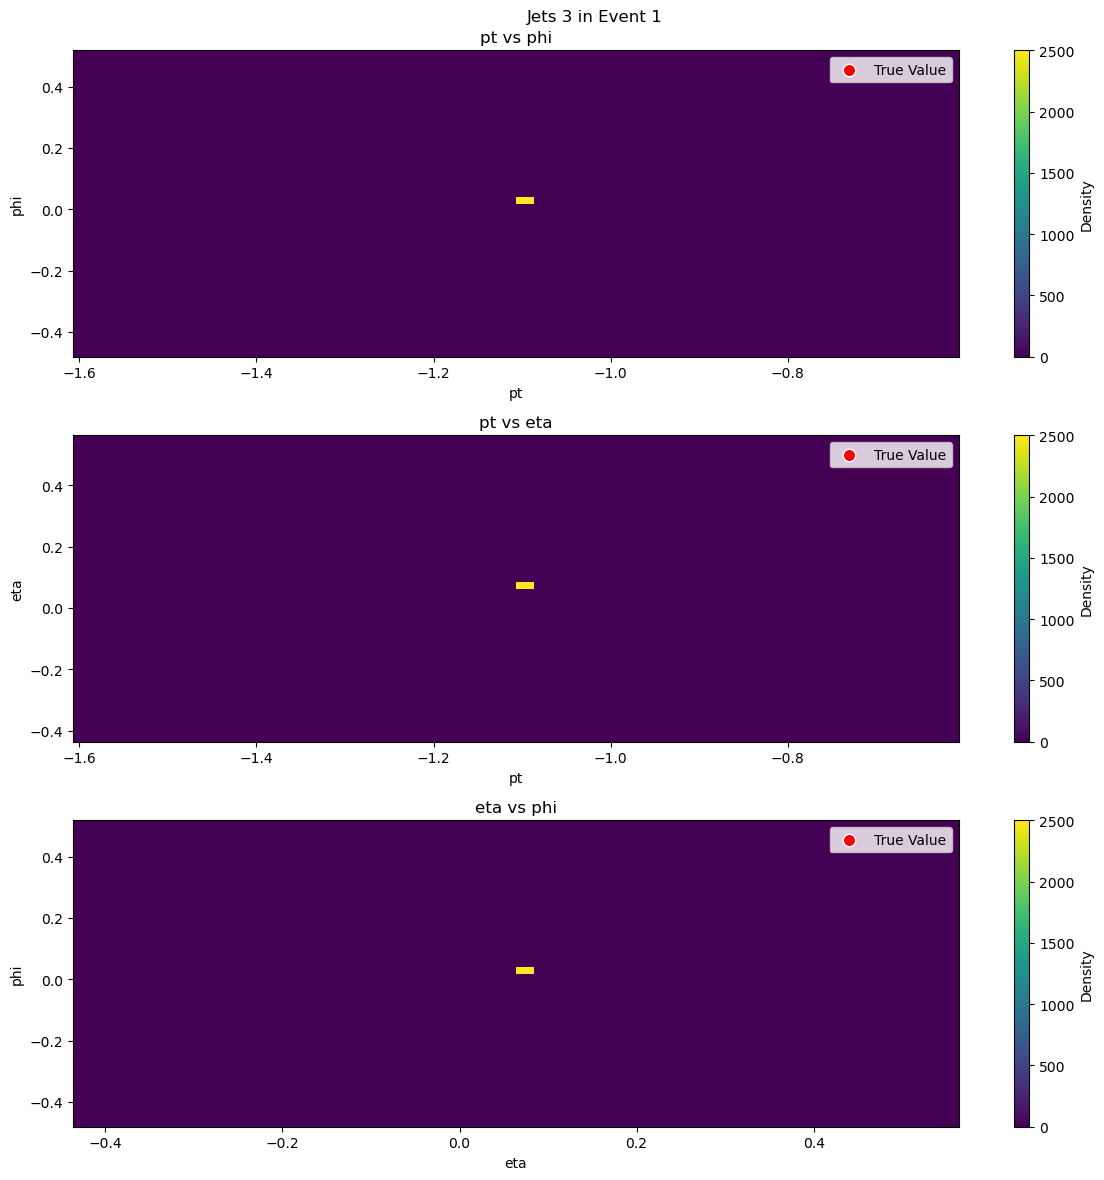

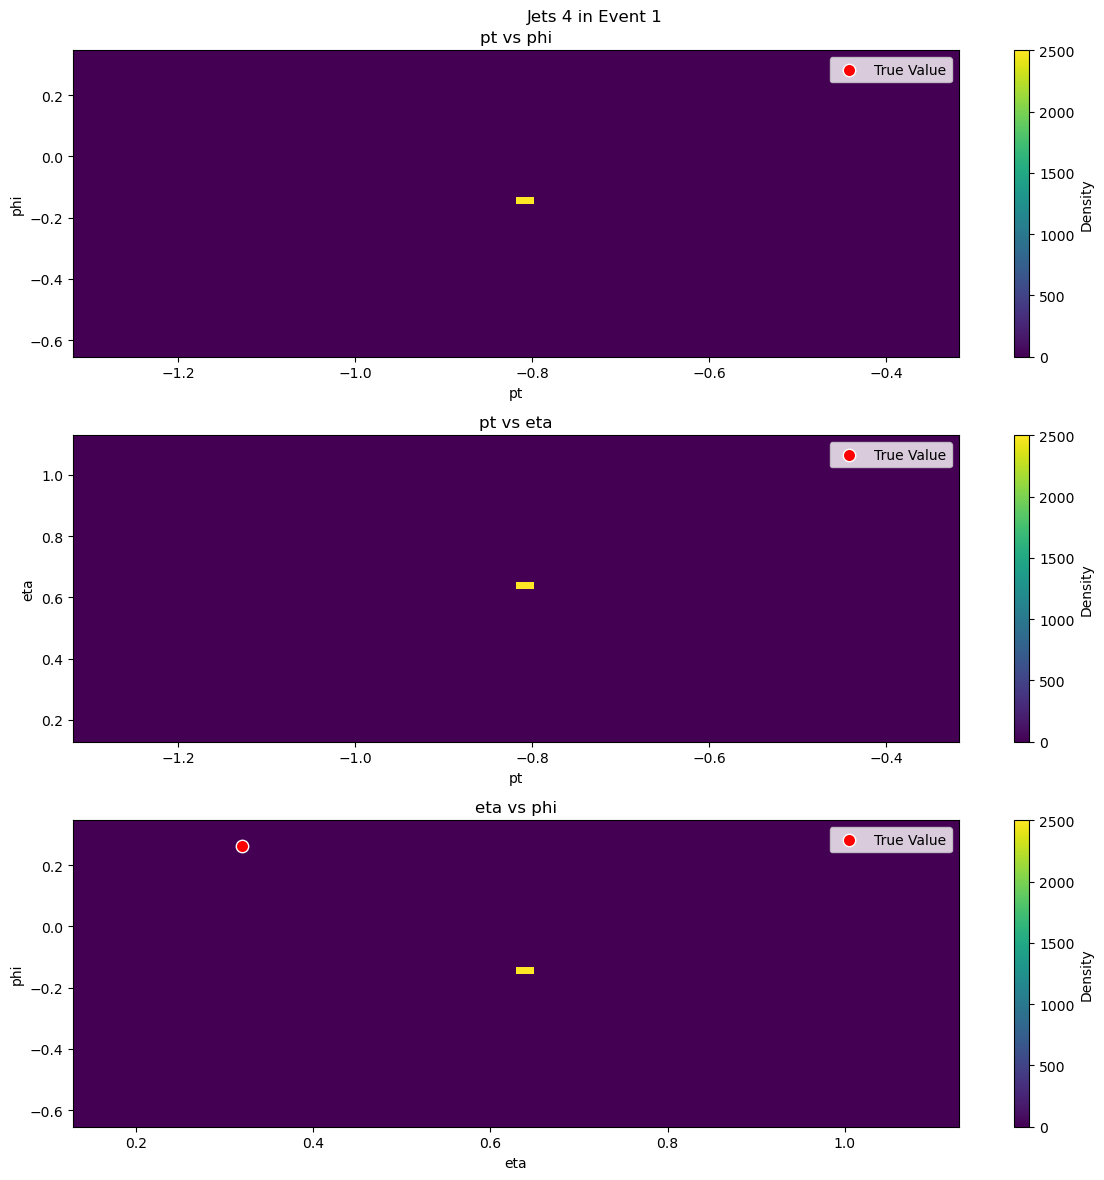

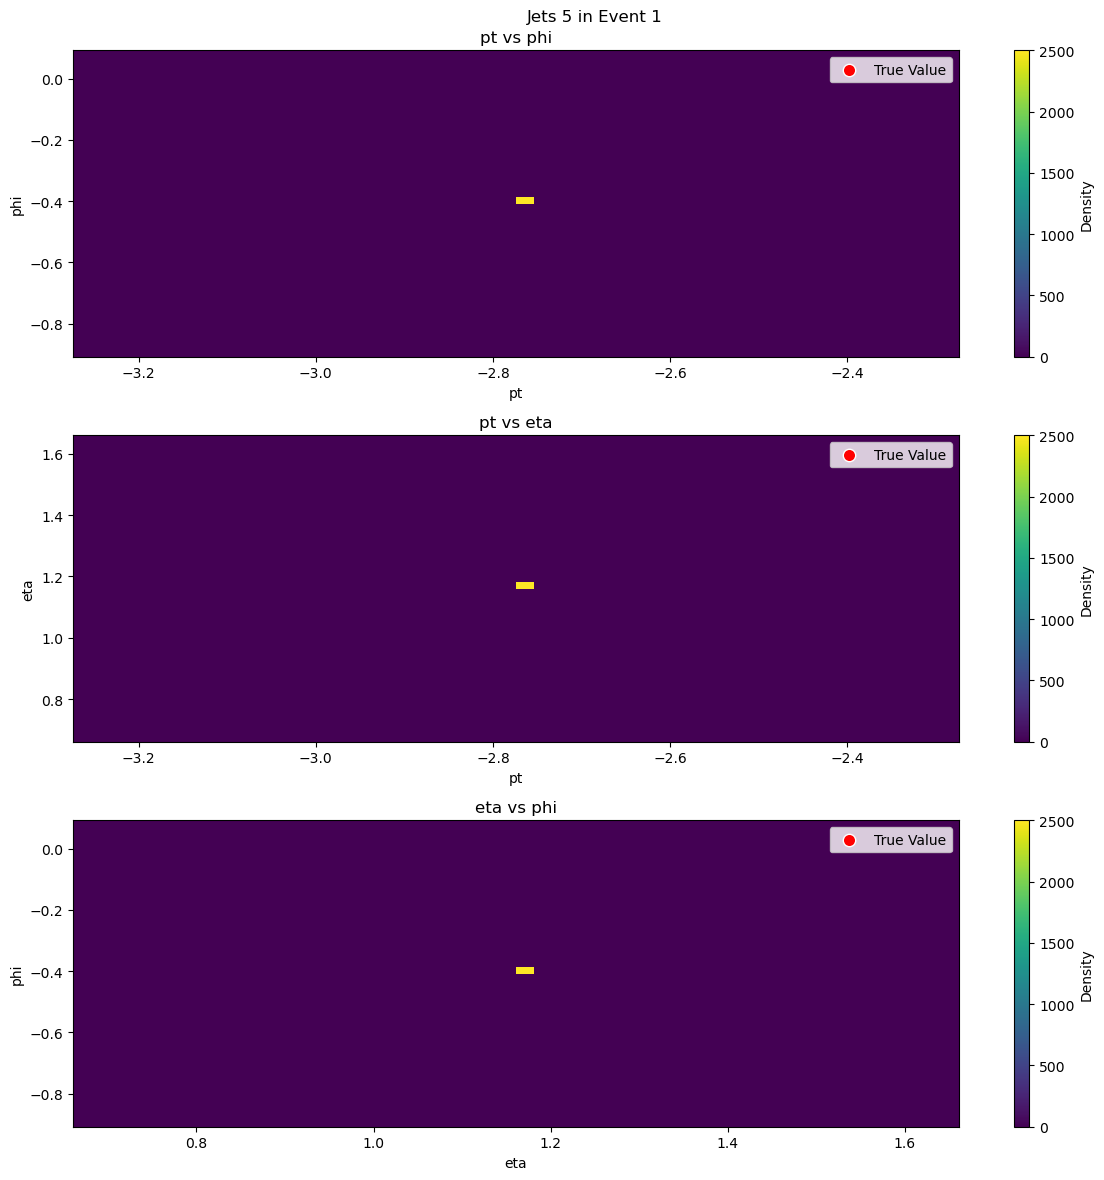

In [22]:
from models.utils import plot_sampling_distributions
def evaluate_model(
    model,
    dataset,
    steps=10,
    num_samples=100,
    event_idx=0,
    plot_sampling_distributions_flag=False,
    object_type="jets"
):
    """
    Evaluate a trained model on a validation dataset and visualize results for the chosen object type.

    Args:
        model: Trained TransferCFM model.
        dataset: Validation dataset (e.g., combined_dataset_valid).
        steps: Number of bridging steps for Euler sampling.
        num_samples: Number of samples for sampling distributions.
        plot_sampling_distributions_flag: Whether to generate sampling distribution plots.
        object_type: Object type to analyze ("jets" or "met").

    Returns:
        None
    """
    obj_idx = 0 if object_type == "jets" else 1  # MET is the second type
    feat_names = ["pt", "eta", "phi"] if object_type == "jets" else ["pt", "phi"]

    # Prepare DataLoader and move a batch to the model's device
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    batch = next(iter(loader))
    batch = CFMSamplingCallback.move_batch_to_device(batch, model.device)

    with torch.no_grad():
        # Generate multiple samples for sampling distributions
        gen_data_samples = [model.sample(batch, steps=steps) for _ in range(num_samples)]

        # Generate a single set of sampled data for direct comparison
        gen_data_list = model.sample(batch, steps=steps)

    # Extract real and generated data for the chosen object type
    real_data = batch["reco"]["data"][obj_idx]  # MET: (B, nFeatures), Jets: (B, nParticles, nFeatures)
    gen_data = gen_data_list[obj_idx]          # Same structure as real_data
    gen_data_samples = [sample[obj_idx] for sample in gen_data_samples]

    # Optionally plot sampling distributions (2D heatmaps)
    if plot_sampling_distributions_flag:
        print(f"Plotting sampling distributions for {object_type} (event 0):")
        plot_sampling_distributions(
            real_data=real_data,
            gen_data_samples=gen_data_samples,
            feat_names=feat_names,
            event_idx=event_idx,
            object_name=object_type,
        )


evaluate_model(
    model=model,
    dataset=combined_dataset_valid,
    steps=10,
    num_samples=10,
    event_idx=1,
    plot_sampling_distributions_flag=True,
    object_type="jets"
)
